In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
plt.rcParams["figure.figsize"] = (20, 6)

In [3]:
df = pd.read_csv('../data/train.csv')

In [4]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2/5/2010,24924.50,False
1,1,1,2/12/2010,46039.49,True
2,1,1,2/19/2010,41595.55,False
3,1,1,2/26/2010,19403.54,False
4,1,1,3/5/2010,21827.90,False


## Prototype Run 

We'll grab a sample dataset and run it through the process as a prototype so we know what we're coding up.

In [69]:
df_train = df[(df.Store==1) & (df.Dept==1)][0:-3]
df_test = df[(df.Store==1) & (df.Dept==1)][-3:]
df_train['Date'] = pd.to_datetime(df['Date'])
df_test['Date'] = pd.to_datetime(df['Date'])

In [70]:
df_train.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday
135,1,1,2012-09-07,18322.37,True
136,1,1,2012-09-14,19616.22,False
137,1,1,2012-09-21,19251.50,False
138,1,1,2012-09-28,18947.81,False
139,1,1,2012-10-05,21904.47,False


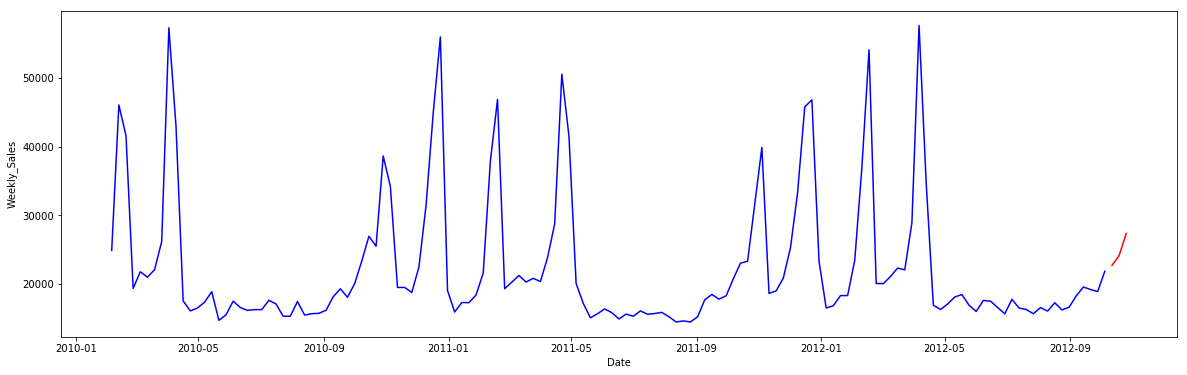

In [71]:
sns.lineplot(data=df_train, x='Date', y='Weekly_Sales', color='blue')
sns.lineplot(data=df_test, x='Date', y='Weekly_Sales', color='red')

In [72]:
from fbprophet import Prophet

In [94]:
# Prepare dataframe for Prophet
df_train.rename(columns={'Date': 'ds', 'Weekly_Sales':'y'}, inplace=True)
# Get Holidays
holidays = df_train[(df_train.Store==1) & (df_train.Dept==1) & (df_train.IsHoliday==True)].ds

df_holidays = pd.DataFrame({
    'holiday': 'holiday',
    'ds': holidays
})
model = Prophet(holidays=df_holidays, weekly_seasonality=10)
model.add_seasonality(name='monthly', period=0.5, fourier_order=10)
model.fit(df_train)
future = model.make_future_dataframe(periods=3, freq='7D')
forecast = model.predict(future)

/Users/kai/anaconda3/envs/kai/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/kai/anaconda3/envs/kai/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


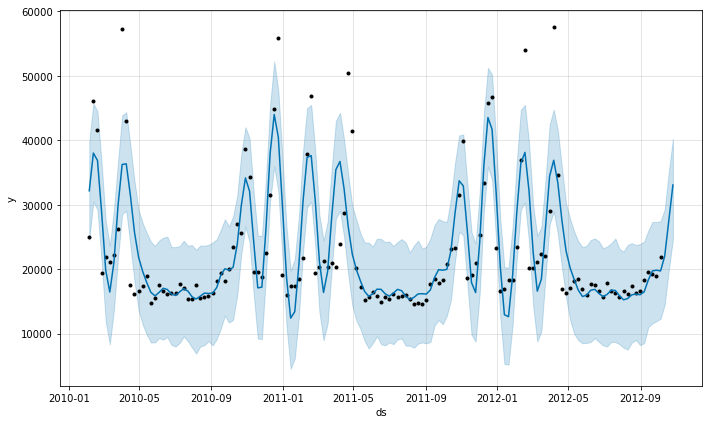

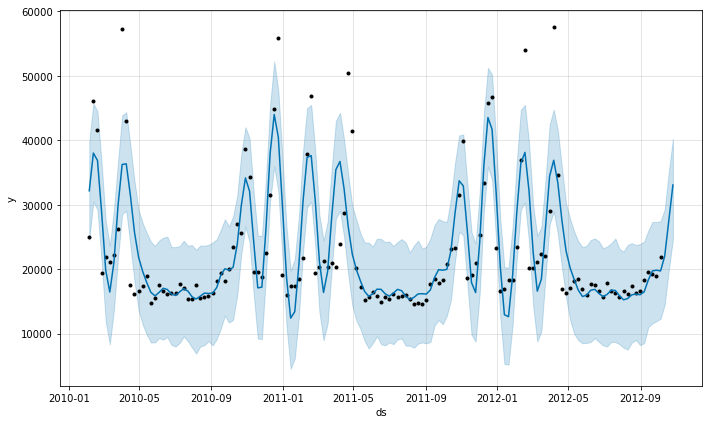

In [95]:
model.plot(forecast)

In [96]:
RMSE = np.sqrt(np.sum((forecast.yhat[-3:] - df_test.Weekly_Sales)**2) / len(df_test))

In [97]:
RMSE

3831.618827035128

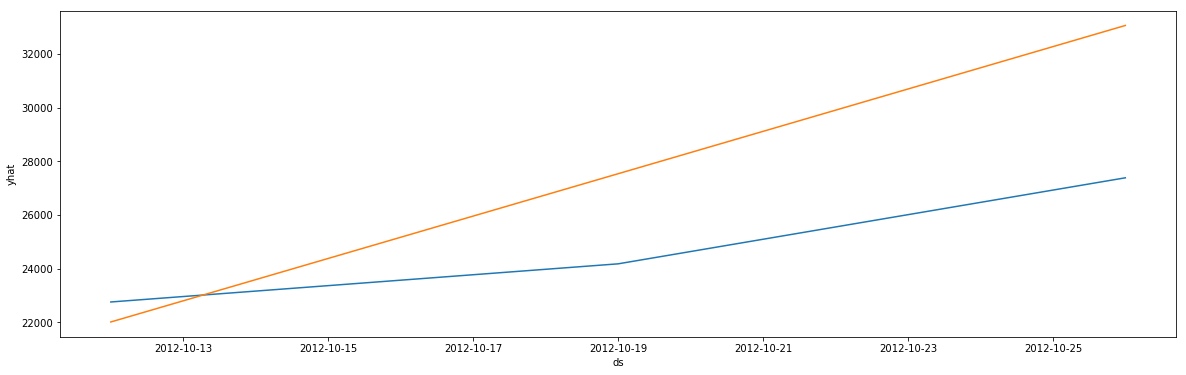

In [101]:
sns.lineplot(data=df_test, x='Date', y='Weekly_Sales')
sns.lineplot(data=forecast[-3:], x='ds', y='yhat')


In [99]:
df_test

,Store,Dept,Date,Weekly_Sales,IsHoliday
140,1,1,2012-10-12,22764.01,False
141,1,1,2012-10-19,24185.27,False
142,1,1,2012-10-26,27390.81,False


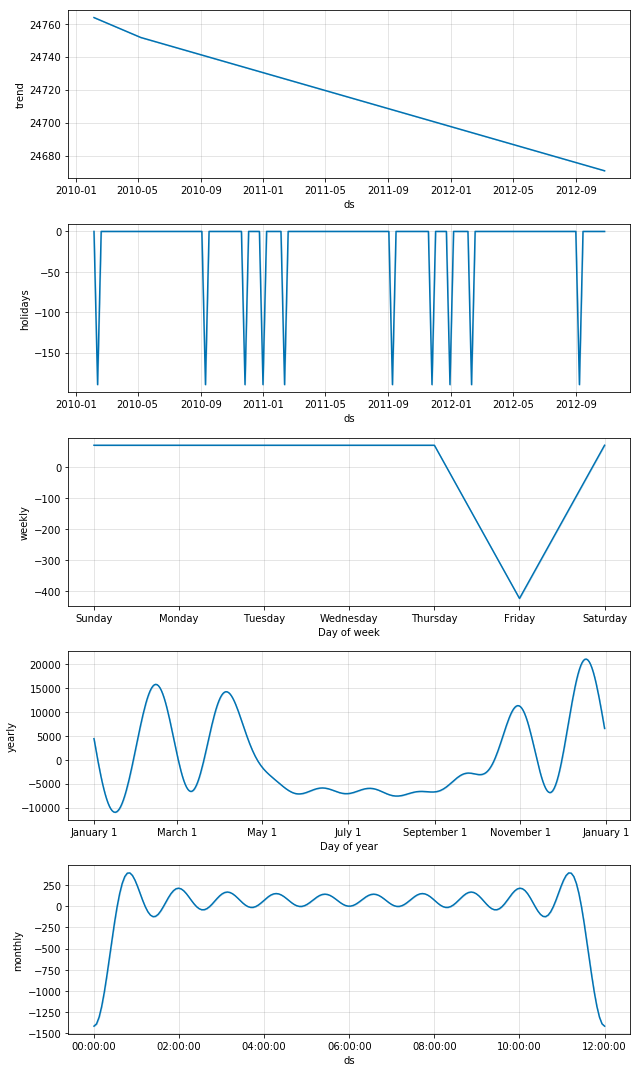

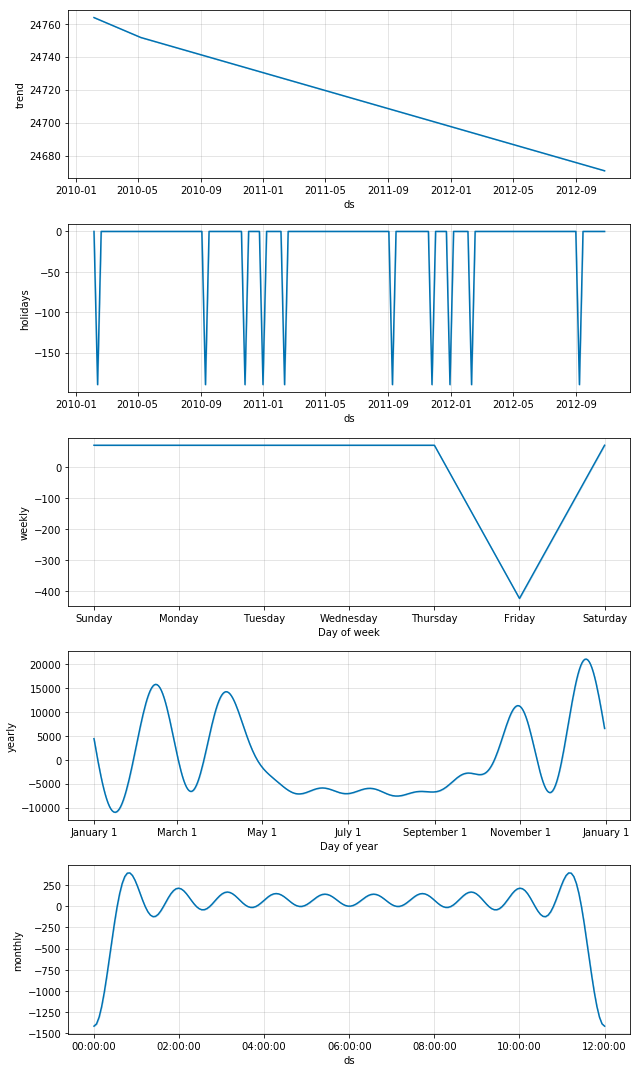

In [93]:
model.plot_components(forecast)

## Explore Results

In [18]:
df_results = pd.read_csv('../data/output.csv')
df_results = df_results.replace([np.inf, -np.inf], np.nan)
df_results = df_results.dropna()
df_results.head()

,Unnamed: 0,Store,Dept,RMSE,Mean_Error_Perc
0,0,1,1,3991.709814,0.161086
1,0,1,2,2792.266545,0.065648
2,0,1,3,1411.518743,0.149173
3,0,1,4,1547.417849,0.043269
4,0,1,5,3981.355239,0.177790


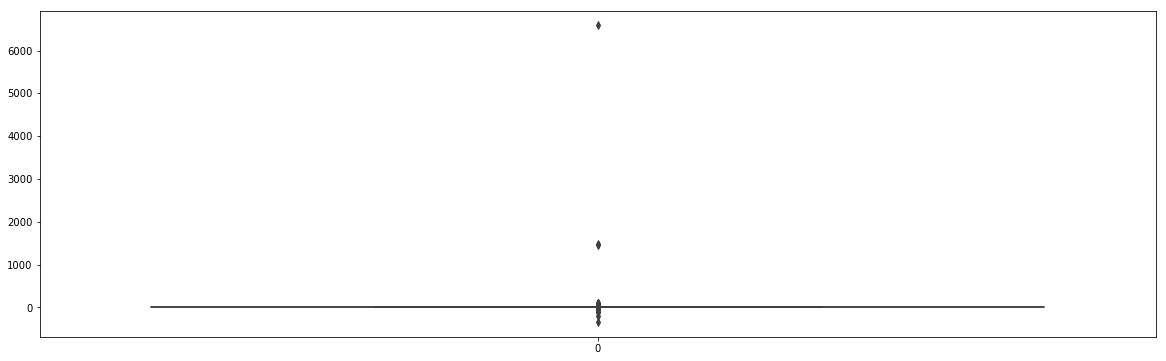

In [20]:
sns.boxplot(data=df_results.Mean_Error_Perc)

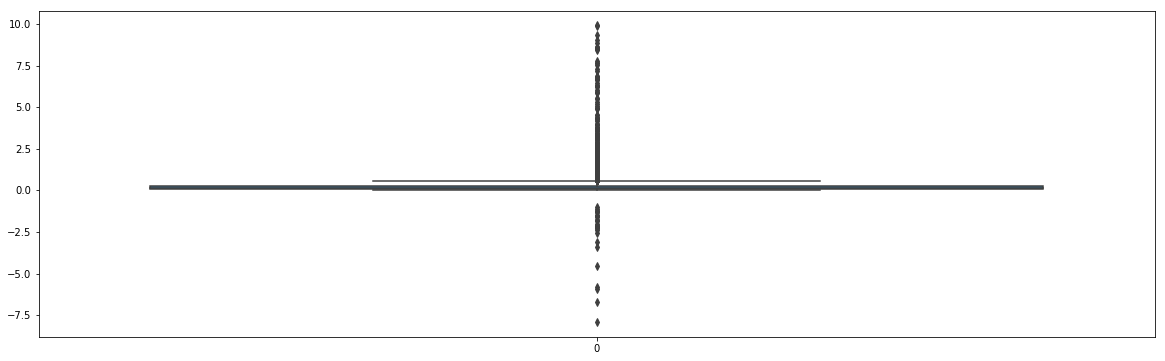

In [33]:
df_minus_outliers = df_results[(df_results['Mean_Error_Perc'] < 10) & (df_results['Mean_Error_Perc'] > -10)]
sns.boxplot(data=df_minus_outliers.Mean_Error_Perc)

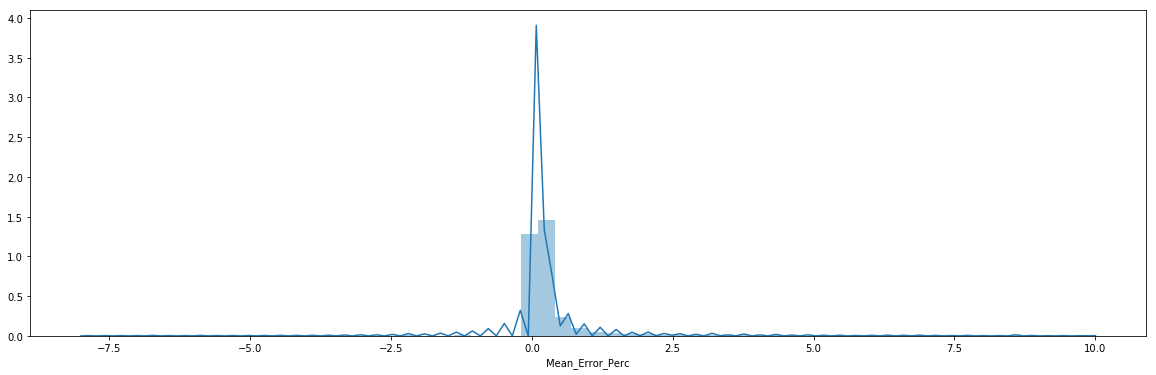

In [34]:
sns.distplot(df_minus_outliers['Mean_Error_Perc'], bins=60)

In [35]:
df_minus_outliers.describe()

,Unnamed: 0,Store,Dept,RMSE,Mean_Error_Perc
count,3168.0,3168.000000,3168.000000,3168.000000,3168.000000
mean,0.0,22.460859,44.671717,1518.852876,0.373907
std,0.0,12.832101,30.046531,2328.327907,0.998702
min,0.0,1.000000,1.000000,0.012910,-7.908685
25%,0.0,11.000000,19.000000,259.822836,0.073245
50%,0.0,22.000000,40.000000,786.228738,0.142294
75%,0.0,33.000000,72.000000,1809.387791,0.280664
max,0.0,45.000000,99.000000,39706.042299,9.907328


In [29]:
df_results.describe()

,Unnamed: 0,Store,Dept,RMSE,Mean_Error_Perc
count,3225.0,3225.000000,3225.000000,3225.000000,3225.000000
mean,0.0,22.449302,45.014264,1516.596161,3.431684
std,0.0,12.815473,30.065238,2375.143717,121.925861
min,0.0,1.000000,1.000000,0.012910,-339.127298
25%,0.0,11.000000,20.000000,247.846317,0.073262
50%,0.0,22.000000,40.000000,775.041788,0.144462
75%,0.0,33.000000,74.000000,1798.515407,0.294257
max,0.0,45.000000,99.000000,39706.042299,6587.205268


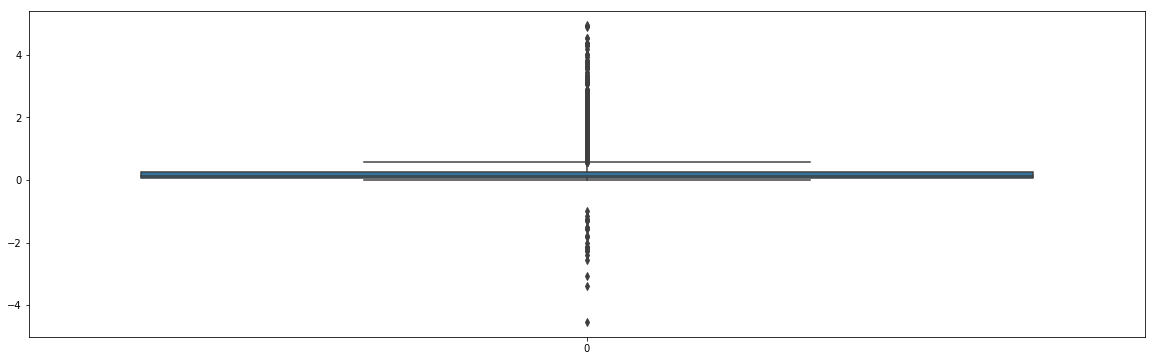

In [36]:
df_minus_outliers = df_results[(df_results['Mean_Error_Perc'] < 5) & (df_results['Mean_Error_Perc'] > -5)]
sns.boxplot(data=df_minus_outliers.Mean_Error_Perc)

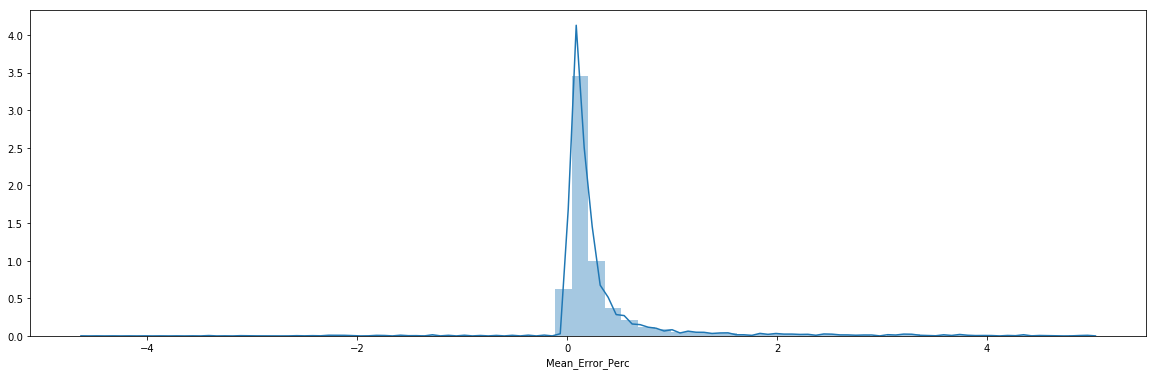

In [37]:
sns.distplot(df_minus_outliers['Mean_Error_Perc'], bins=60)

In [38]:
df_minus_outliers.describe()

,Unnamed: 0,Store,Dept,RMSE,Mean_Error_Perc
count,3128.0,3128.000000,3128.000000,3128.000000,3128.000000
mean,0.0,22.426790,44.532289,1535.279629,0.304207
std,0.0,12.832557,30.095917,2338.075131,0.619747
min,0.0,1.000000,1.000000,0.012910,-4.537585
25%,0.0,11.000000,19.000000,273.123361,0.073010
50%,0.0,22.000000,38.000000,802.476532,0.140726
75%,0.0,33.000000,72.000000,1819.859498,0.272144
max,0.0,45.000000,99.000000,39706.042299,4.940201


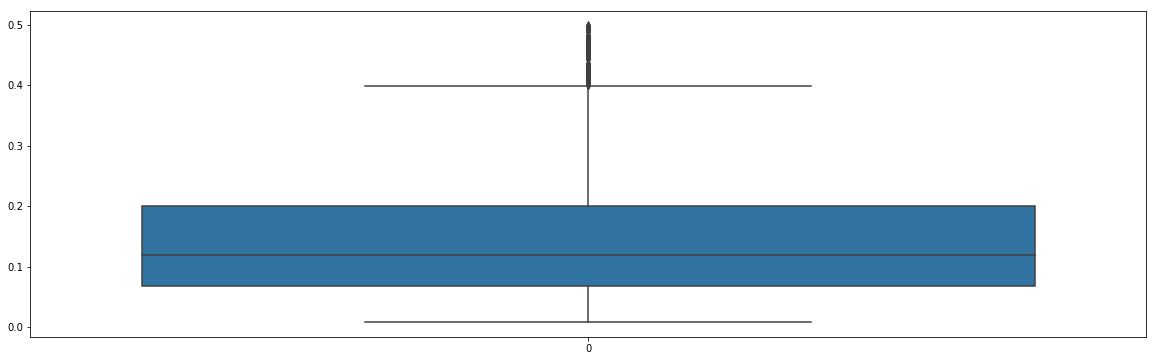

In [40]:
df_minus_outliers = df_results[(df_results['Mean_Error_Perc'] < .5) & (df_results['Mean_Error_Perc'] > -.5)]
sns.boxplot(data=df_minus_outliers.Mean_Error_Perc)

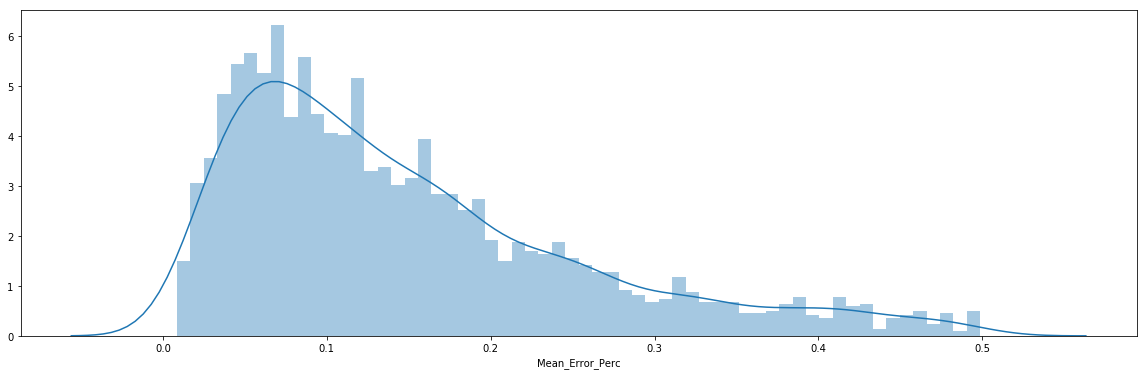

In [102]:
sns.distplot(df_minus_outliers['Mean_Error_Perc'], bins=60)


In [103]:
df_minus_outliers.describe()

,Unnamed: 0,Store,Dept,RMSE,Mean_Error_Perc
count,2681.0,2681.000000,2681.000000,2681.000000,2681.000000
mean,0.0,22.119358,43.639687,1693.519606,0.149345
std,0.0,12.814955,31.047195,2331.147546,0.107351
min,0.0,1.000000,1.000000,0.222402,0.008632
25%,0.0,11.000000,17.000000,392.355720,0.067688
50%,0.0,22.000000,35.000000,930.934840,0.120019
75%,0.0,33.000000,74.000000,2030.125149,0.200578
max,0.0,45.000000,98.000000,29849.998677,0.498651


## Outliers
So it looks like we might have some extreme outliers that are influencing the aggregate, let's look at one of them.

In [48]:
df_train = df[(df.Store==30) & (df.Dept==99)][0:-3]
df_test = df[(df.Store==30) & (df.Dept==99)][-3:]
df_train['Date'] = pd.to_datetime(df['Date'])
df_test['Date'] = pd.to_datetime(df['Date'])

In [50]:
df_train.describe()

,Store,Dept,Weekly_Sales
count,8.0,8.0,8.000000
mean,30.0,99.0,-0.890000
std,0.0,0.0,2.362608
min,30.0,99.0,-6.720000
25%,30.0,99.0,-0.117500
50%,30.0,99.0,0.015000
75%,30.0,99.0,0.020000
max,30.0,99.0,0.020000


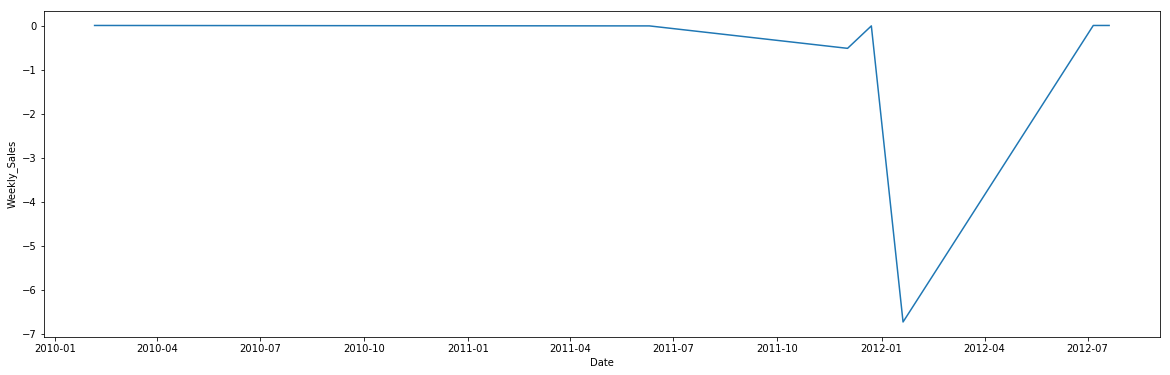

In [51]:
sns.lineplot(data=df_train, x='Date', y='Weekly_Sales')

In [52]:
df_train

,Store,Dept,Date,Weekly_Sales,IsHoliday
293693,30,99,2010-02-05,0.02,False
293694,30,99,2011-06-10,0.01,False
293695,30,99,2011-12-02,-0.50,False
293696,30,99,2011-12-23,0.01,False
293697,30,99,2012-01-20,-6.72,False
293698,30,99,2012-07-06,0.02,False
293699,30,99,2012-07-13,0.02,False
293700,30,99,2012-07-20,0.02,False


In [54]:
df_results[df_results.Mean_Error_Perc > .5].shape

(502, 5)

It's pretty obvious any method we choose is going to have a hard time modeling this. There's big gaps in the data, and the spread is actually quite large from observation to observation. We can already intuit, this is likely to cause the model to overestimate wave patterns.

In [55]:
# Prepare dataframe for Prophet
df_train.rename(columns={'Date': 'ds', 'Weekly_Sales':'y'}, inplace=True)
# Get Holidays
holidays = df_train[(df_train.Store==1) & (df_train.Dept==1) & (df_train.IsHoliday==True)].ds

df_holidays = pd.DataFrame({
    'holiday': 'holiday',
    'ds': holidays
})
model = Prophet(holidays=df_holidays)
model.fit(df_train)
future = model.make_future_dataframe(periods=3, freq='7D')
forecast = model.predict(future)

/Users/kai/anaconda3/envs/kai/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 5.0.
/Users/kai/anaconda3/envs/kai/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


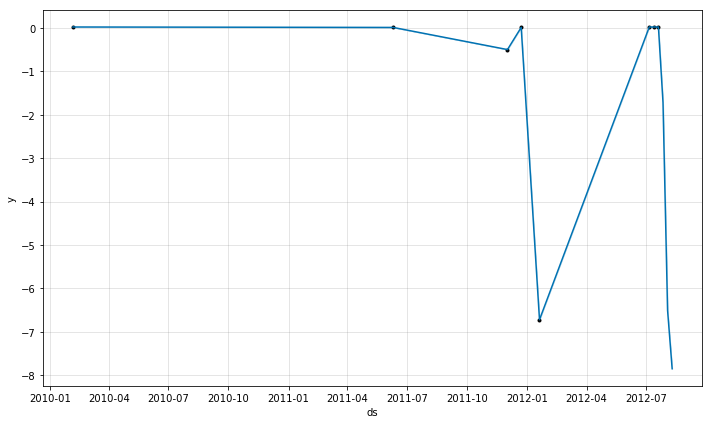

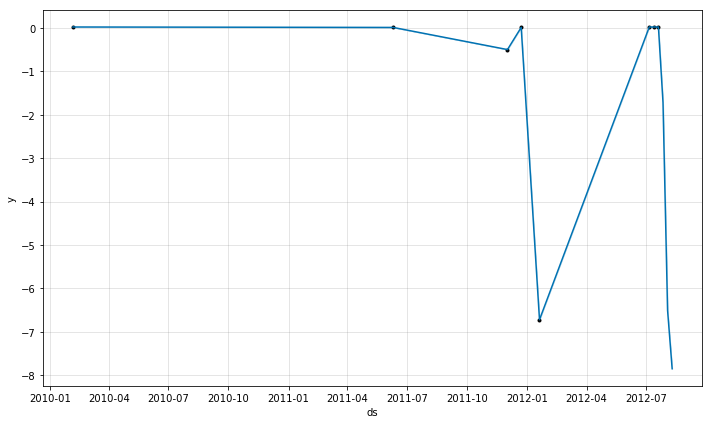

In [56]:
model.plot(forecast)

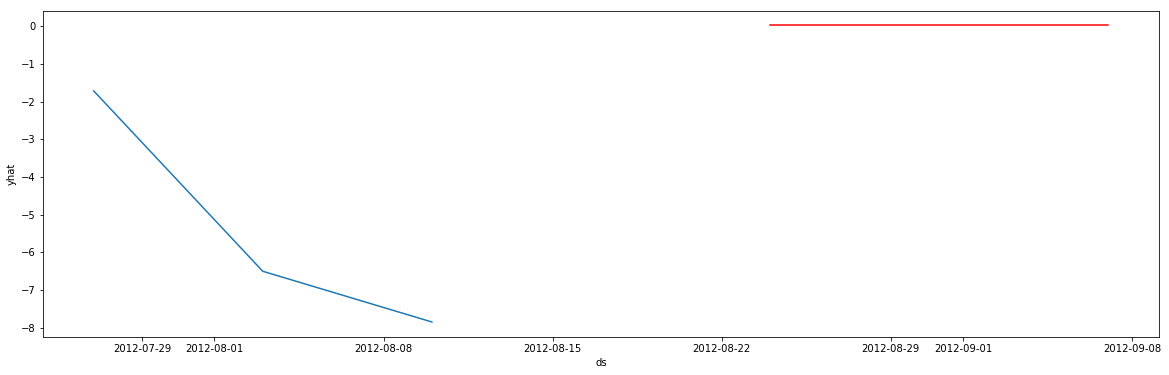

In [66]:
sns.lineplot(data=df_test, x='Date', y='Weekly_Sales', color='red')
sns.lineplot(data=forecast[-3:], x='ds', y='yhat')

,Store,Dept,Date,Weekly_Sales,IsHoliday
293701,30,99,2012-08-24,0.02,False
293702,30,99,2012-08-31,0.02,False
293703,30,99,2012-09-07,0.02,True


In [65]:
forecast.tail()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
6,2012-07-13,25.710599,0.020000,0.020000,25.710599,25.710599,-25.690599,-25.690599,-25.690599,-25.690599,-25.690599,-25.690599,0.0,0.0,0.0,0.020000
7,2012-07-20,25.797845,0.020000,0.020000,25.797845,25.797845,-25.777845,-25.777845,-25.777845,-25.777845,-25.777845,-25.777845,0.0,0.0,0.0,0.020000
8,2012-07-27,25.885090,-1.715763,-1.715763,25.885090,25.885090,-27.600853,-27.600853,-27.600853,-27.600853,-27.600853,-27.600853,0.0,0.0,0.0,-1.715763
9,2012-08-03,25.972335,-6.503347,-6.503347,25.972335,25.972335,-32.475682,-32.475682,-32.475682,-32.475682,-32.475682,-32.475682,0.0,0.0,0.0,-6.503347
10,2012-08-10,26.059580,-7.849135,-7.849135,26.059580,26.059580,-33.908716,-33.908716,-33.908716,-33.908716,-33.908716,-33.908716,0.0,0.0,0.0,-7.849135


In [67]:
df_test

,Store,Dept,Date,Weekly_Sales,IsHoliday
293701,30,99,2012-08-24,0.02,False
293702,30,99,2012-08-31,0.02,False
293703,30,99,2012-09-07,0.02,True


In [68]:
df_train

,Store,Dept,ds,y,IsHoliday
293693,30,99,2010-02-05,0.02,False
293694,30,99,2011-06-10,0.01,False
293695,30,99,2011-12-02,-0.50,False
293696,30,99,2011-12-23,0.01,False
293697,30,99,2012-01-20,-6.72,False
293698,30,99,2012-07-06,0.02,False
293699,30,99,2012-07-13,0.02,False
293700,30,99,2012-07-20,0.02,False


So, here's a big problem. We assumed that the data was continuous on a weekly basis but it clearly isn't. It isn't entirely clear if this indicates that the missing values denote no value or something else. 